In [ ]:
import sys
import os
import re
import numpy as np
sys.path.insert(0, 'src/')

import pandas as pd
from src.table_utils import (
collect_scores_into_dict,
extract_same_different_dataframes,
ood_detection_pairs_,
aggregate_over_measures,
)
from IPython.display import display
pd.set_option('display.max_rows', None)

In [2]:
# full_ood_rocauc[full_ood_rocauc.base_rule == 'Spherical'].sort_values(by='RocAucScore')

In [3]:
full_ood_rocauc = pd.read_csv('./tables/full_ood_rocauc.csv', index_col=0)

In [4]:
full_ood_rocauc = full_ood_rocauc[~full_ood_rocauc.UQMetric.str.endswith('Inner Inner')]

In [5]:
full_ood_rocauc.sample(10)

,UQMetric,Dataset,LossFunction,RocAucScore,architecture,training_dataset,base_rule,RiskType
94,Total Logscore Inner,cifar100,Logscore,0.921952,resnet18,cifar10,Logscore,Total
345,Excess Logscore Outer Outer,cifar10,Brier,0.713878,resnet18,noisy_cifar100,Logscore,Excess
951,Bias Maxprob,svhn,Brier,0.199104,vgg,cifar100,Maxprob,Bias
386,Excess Maxprob Outer Outer,blurred_cifar100,Spherical,0.721680,vgg,cifar100,Maxprob,Excess
227,Bayes Maxprob Outer,cifar10,Spherical,0.815845,resnet18,cifar100,Maxprob,Bayes
641,Bregman Information Maxprob,blurred_cifar100,Spherical,0.738950,resnet18,cifar100,Maxprob,Bregman Information
1037,MVBI Spherical,cifar10,Spherical,0.694246,resnet18,noisy_cifar100,Spherical,MVBI
661,Bregman Information Spherical,cifar10,Logscore,0.500000,resnet18,missed_class_cifar10,Spherical,Bregman Information
1070,Bias Neglog,cifar100,Spherical,0.635786,resnet18,missed_class_cifar10,Neglog,Bias
1024,MV Spherical,cifar100,Logscore,0.500000,resnet18,cifar100,Spherical,MV


In [6]:
full_ood_rocauc.loc[(full_ood_rocauc.RiskType == "Bayes") & full_ood_rocauc.UQMetric.str.endswith("Outer"), "RiskType"] = 'Bayes Outer'
full_ood_rocauc.loc[(full_ood_rocauc.RiskType == "Bayes") & full_ood_rocauc.UQMetric.str.endswith("Inner"), "RiskType"] = 'Bayes Inner'

full_ood_rocauc.loc[(full_ood_rocauc.RiskType == "Total") & full_ood_rocauc.UQMetric.str.endswith("Outer"), "RiskType"] = 'Total Outer'
full_ood_rocauc.loc[(full_ood_rocauc.RiskType == "Total") & full_ood_rocauc.UQMetric.str.endswith("Inner"), "RiskType"] = 'Total Inner'

In [7]:
# trunc_df = full_ood_rocauc[
# ~full_ood_rocauc.RiskType.isin(['Bias', 'MV', 'MVBI', 'BiasBI', 'Bregman Information', 'Reverse Bregman Information']) &
# # full_ood_rocauc.base_rule.isin(['Brier', 'Logscore', 'Spherical']) &
# # full_ood_rocauc.LossFunction.isin(['Brier', 'Logscore', 'Spherical']) &
# ~(np.isclose(full_ood_rocauc.RocAucScore, np.float64(0.5)))
# ]

# # trunc_df.sort_values(by='RocAucScore')

# trunc_df.to_csv(os.path.join('tables', 'full_ood_rocauc_only_risks.csv'), index=False)

In [8]:
# full_ood_rocauc[
# (full_ood_rocauc.RiskType != 'Bias') &
# (full_ood_rocauc.base_rule == 'Neglog')
# ].sort_values(by=['RocAucScore'])

In [9]:
# full_ood_rocauc = full_ood_rocauc[full_ood_rocauc.base_rule != 'Neglog']

In [10]:
grouped_df = extract_same_different_dataframes(
    dataframe_=full_ood_rocauc,
)

In [11]:
same_dict, _ = collect_scores_into_dict(
    dataframes_list=[
        grouped_df.logscore_logscore,
        grouped_df.brier_brier,
        grouped_df.spherical_spherical,
    ],
    ood_detection_pairs=ood_detection_pairs_,
)
same_df = pd.DataFrame.from_dict(same_dict)

same_agg_df = aggregate_over_measures(
    dataframe_=same_df,
    agg_func_='mean',
    by_=['InD', 'OOD'],
)

In [12]:
different_dict, _ = collect_scores_into_dict(
    dataframes_list=[
        grouped_df.logscore_not_logscore,
        grouped_df.brier_not_brier,
        grouped_df.spherical_not_spherical,
    ],
    ood_detection_pairs=ood_detection_pairs_,
)
different_df = pd.DataFrame.from_dict(different_dict)

different_agg_df = aggregate_over_measures(
    dataframe_=different_df,
    agg_func_='mean',
    by_=['InD', 'OOD'],
)

In [13]:
all_dict, _ = collect_scores_into_dict(
    dataframes_list=[
        full_ood_rocauc,
    ],
    ood_detection_pairs=ood_detection_pairs_,
)
all_df = pd.DataFrame.from_dict(all_dict)

all_agg_df = aggregate_over_measures(
    dataframe_=all_df,
    agg_func_='mean',
    by_=['InD', 'OOD'],
)

In [14]:
display(all_agg_df)
display(same_agg_df)
display(different_agg_df)

Total Outer Total Inner Bayes Inner Bayes Outer  \
                                 mean        mean        mean        mean   
InD      OOD                                                                
cifar10  blurred_cifar10     0.866536    0.853090    0.853090    0.826965   
         blurred_cifar100    0.956324    0.950800    0.950800    0.935119   
         cifar100            0.905910    0.909920    0.909920    0.909563   
         svhn                0.941423    0.945143    0.945143    0.944335   
cifar100 blurred_cifar10     0.878724    0.889896    0.889896    0.864338   
         blurred_cifar100    0.747711    0.725706    0.725706    0.695672   
         cifar10             0.752243    0.791126    0.791126    0.788203   
         svhn                0.803006    0.849334    0.849334    0.848893   

                             Excess Bregman Information  \
                               mean                mean   
InD      OOD                                              
cifar10  blurred_cifar10   0.868306            0.867800   
         blurred_cifar100  0.950863            0.951213   
         cifar100          0.885812            0.887123   
         svhn              0.921780            0.922266   
cifar100 blurred_cifar10   0.784151            0.787492   
         blurred_cifar100  0.737750            0.728504   
         cifar10           0.658923            0.664299   
         svhn              0.671667            0.679762   

                          Reverse Bregman Information  \
                                                 mean   
InD      OOD                                            
cifar10  blurred_cifar10                     0.867567   
         blurred_cifar100                    0.949054   
         cifar100                            0.884213   
         svhn                                0.920479   
cifar100 blurred_cifar10                     0.769291   
         blurred_cifar100                    0.739952   
         cifar10                             0.650057   
         svhn                                0.660314   

                          Expected Pairwise Bregman Information      Bias  \
                                                           mean      mean   
InD      OOD                                                                
cifar10  blurred_cifar10                               0.869551  0.660660   
         blurred_cifar100                              0.952321  0.674925   
         cifar100                                      0.886100  0.648434   
         svhn                                          0.922596  0.661076   
cifar100 blurred_cifar10                               0.795670  0.541619   
         blurred_cifar100                              0.744794  0.568505   
         cifar10                                       0.662414  0.482271   
         svhn                                          0.674925  0.486484   

                                 MV      MVBI    BiasBI  
                               mean      mean      mean  
InD      OOD                                             
cifar10  blurred_cifar10   0.802464  0.865765  0.750017  
         blurred_cifar100  0.863725  0.950518  0.787422  
         cifar100          0.818162  0.887980  0.744753  
         svhn              0.844470  0.924062  0.763130  
cifar100 blurred_cifar10   0.730607  0.807259  0.620265  
         blurred_cifar100  0.699635  0.744755  0.628850  
         cifar10           0.623093  0.671924  0.541911  
         svhn              0.625822  0.680426  0.539022

Total Outer Total Inner Bayes Inner Bayes Outer  \
                                 mean        mean        mean        mean   
InD      OOD                                                                
cifar10  blurred_cifar10     0.862998    0.854926    0.854926    0.832594   
         blurred_cifar100    0.956178    0.952183    0.952183    0.937482   
         cifar100            0.907467    0.909927    0.909927    0.911068   
         svhn                0.943443    0.945436    0.945436    0.945453   
cifar100 blurred_cifar10     0.914538    0.891840    0.891840    0.867418   
         blurred_cifar100    0.756761    0.726193    0.726193    0.701755   
         cifar10             0.790967    0.794445    0.794445    0.792496   
         svhn                0.843255    0.848508    0.848508    0.849544   

                             Excess Bregman Information  \
                               mean                mean   
InD      OOD                                              
cifar10  blurred_cifar10   0.878007            0.876301   
         blurred_cifar100  0.956472            0.956019   
         cifar100          0.900770            0.901993   
         svhn              0.933077            0.933888   
cifar100 blurred_cifar10   0.853572            0.858332   
         blurred_cifar100  0.775527            0.767559   
         cifar10           0.726959            0.734864   
         svhn              0.739940            0.750673   

                          Reverse Bregman Information  \
                                                 mean   
InD      OOD                                            
cifar10  blurred_cifar10                     0.879345   
         blurred_cifar100                    0.956756   
         cifar100                            0.899631   
         svhn                                0.932275   
cifar100 blurred_cifar10                     0.844763   
         blurred_cifar100                    0.780346   
         cifar10                             0.718211   
         svhn                                0.728042   

                          Expected Pairwise Bregman Information      Bias  \
                                                           mean      mean   
InD      OOD                                                                
cifar10  blurred_cifar10                               0.878376  0.742875   
         blurred_cifar100                              0.956642  0.788508   
         cifar100                                      0.900687  0.754901   
         svhn                                          0.933069  0.776912   
cifar100 blurred_cifar10                               0.857620  0.705564   
         blurred_cifar100                              0.778675  0.683394   
         cifar10                                       0.727801  0.609855   
         svhn                                          0.741104  0.625403   

                                 MV      MVBI    BiasBI  
                               mean      mean      mean  
InD      OOD                                             
cifar10  blurred_cifar10   0.876733  0.876695  0.879063  
         blurred_cifar100  0.954771  0.955415  0.957182  
         cifar100          0.899628  0.900749  0.900815  
         svhn              0.931760  0.932753  0.933303  
cifar100 blurred_cifar10   0.841490  0.856035  0.860863  
         blurred_cifar100  0.767353  0.770708  0.779179  
         cifar10           0.722217  0.730338  0.729680  
         svhn              0.729552  0.742918  0.746241

Total Outer Total Inner Bayes Inner Bayes Outer  \
                                 mean        mean        mean        mean   
InD      OOD                                                                
cifar10  blurred_cifar10     0.867420    0.852631    0.852631    0.825558   
         blurred_cifar100    0.956361    0.950454    0.950454    0.934528   
         cifar100            0.905521    0.909918    0.909918    0.909187   
         svhn                0.940918    0.945069    0.945069    0.944056   
cifar100 blurred_cifar10     0.869771    0.889410    0.889410    0.863569   
         blurred_cifar100    0.745449    0.725584    0.725584    0.694151   
         cifar10             0.742562    0.790296    0.790296    0.787129   
         svhn                0.792944    0.849541    0.849541    0.848731   

                             Excess Bregman Information  \
                               mean                mean   
InD      OOD                                              
cifar10  blurred_cifar10   0.865881            0.865675   
         blurred_cifar100  0.949460            0.950012   
         cifar100          0.882072            0.883405   
         svhn              0.918956            0.919361   
cifar100 blurred_cifar10   0.766796            0.769782   
         blurred_cifar100  0.728306            0.718740   
         cifar10           0.641915            0.646658   
         svhn              0.654599            0.662034   

                          Reverse Bregman Information  \
                                                 mean   
InD      OOD                                            
cifar10  blurred_cifar10                     0.864623   
         blurred_cifar100                    0.947128   
         cifar100                            0.880358   
         svhn                                0.917530   
cifar100 blurred_cifar10                     0.750424   
         blurred_cifar100                    0.729854   
         cifar10                             0.633018   
         svhn                                0.643382   

                          Expected Pairwise Bregman Information      Bias  \
                                                           mean      mean   
InD      OOD                                                                
cifar10  blurred_cifar10                               0.867344  0.640106   
         blurred_cifar100                              0.951241  0.646530   
         cifar100                                      0.882453  0.621818   
         svhn                                          0.919977  0.632117   
cifar100 blurred_cifar10                               0.780182  0.500633   
         blurred_cifar100                              0.736324  0.539783   
         cifar10                                       0.646067  0.450375   
         svhn                                          0.658381  0.451754   

                                 MV      MVBI    BiasBI  
                               mean      mean      mean  
InD      OOD                                             
cifar10  blurred_cifar10   0.783897  0.863032  0.717755  
         blurred_cifar100  0.840964  0.949293  0.744982  
         cifar100          0.797796  0.884787  0.705737  
         svhn              0.822647  0.921890  0.720587  
cifar100 blurred_cifar10   0.702887  0.795065  0.560116  
         blurred_cifar100  0.682705  0.738267  0.591268  
         cifar10           0.598313  0.657320  0.494969  
         svhn              0.599890  0.664803  0.487217

In [15]:
(same_agg_df - different_agg_df) / different_agg_df * 100

Total Outer Total Inner Bayes Inner Bayes Outer  \
                                 mean        mean        mean        mean   
InD      OOD                                                                
cifar10  blurred_cifar10    -0.509738    0.269179    0.269179    0.852162   
         blurred_cifar100   -0.019136    0.181881    0.181881    0.316115   
         cifar100            0.214914    0.001027    0.001027    0.206975   
         svhn                0.268292    0.038803    0.038803    0.147923   
cifar100 blurred_cifar10     5.147023    0.273158    0.273158    0.445772   
         blurred_cifar100    1.517402    0.083983    0.083983    1.095461   
         cifar10             6.518565    0.525031    0.525031    0.681810   
         svhn                6.344892   -0.121529   -0.121529    0.095839   

                              Excess Bregman Information  \
                                mean                mean   
InD      OOD                                               
cifar10  blurred_cifar10    1.400479            1.227380   
         blurred_cifar100   0.738526            0.632310   
         cifar100           2.119807            2.104120   
         svhn               1.536685            1.580170   
cifar100 blurred_cifar10   11.316680           11.503281   
         blurred_cifar100   6.483645            6.792280   
         cifar10           13.248542           13.640329   
         svhn              13.037129           13.388909   

                          Reverse Bregman Information  \
                                                 mean   
InD      OOD                                            
cifar10  blurred_cifar10                     1.702765   
         blurred_cifar100                    1.016533   
         cifar100                            2.189179   
         svhn                                1.607072   
cifar100 blurred_cifar10                    12.571472   
         blurred_cifar100                    6.918211   
         cifar10                            13.458176   
         svhn                               13.158715   

                          Expected Pairwise Bregman Information       Bias  \
                                                           mean       mean   
InD      OOD                                                                 
cifar10  blurred_cifar10                               1.271907  16.054943   
         blurred_cifar100                              0.567799  21.960057   
         cifar100                                      2.066305  21.402198   
         svhn                                          1.423030  22.906476   
cifar100 blurred_cifar10                               9.925638  40.934306   
         blurred_cifar100                              5.751633  26.605389   
         cifar10                                      12.650998  35.410572   
         svhn                                         12.564581  38.438683   

                                  MV       MVBI     BiasBI  
                                mean       mean       mean  
InD      OOD                                                
cifar10  blurred_cifar10   11.842995   1.583135  22.473856  
         blurred_cifar100  13.532907   0.644933  28.483916  
         cifar100          12.764164   1.803994  27.641685  
         svhn              13.263570   1.178338  29.519830  
cifar100 blurred_cifar10   19.719178   7.668554  53.693719  
         blurred_cifar100  12.398986   4.394120  31.780974  
         cifar10           20.709056  11.108369  47.419366  
         svhn              21.614327  11.750093  53.163875

In [16]:
full_scores = pd.read_csv('./tables/full_dataframe.csv', )

In [17]:
full_scores.sample(10)

,Unnamed: 0,UQMetric,LossFunction,Dataset,Scores,architecture,training_dataset,base_rule,RiskType
3075,825,Bias Logscore,Brier,cifar10,"[0.029259672, 0.009489992, 0.0068538897, 0.012...",resnet18,cifar100,Logscore,Bias
5847,222,Bayes Maxprob Inner,Spherical,svhn,"[0.6144406, 0.67432004, 0.69950145, 0.623045, ...",resnet18,missed_class_cifar10,Maxprob,Bayes
1777,652,Bregman Information Neglog,Logscore,svhn,"[22.1292, 12.970472, 18.699877, 24.415483, 16....",vgg,cifar10,Neglog,Bregman Information
1389,264,Bayes Neglog Outer,Logscore,blurred_cifar10,"[-90.341576, -70.63559, -60.080994, -86.26534,...",vgg,cifar10,Neglog,Bayes
1714,589,Excess Spherical Inner Inner,Brier,blurred_cifar10,"[0.0, -9.573977e-08, 0.0, 5.5124037e-08, 7.500...",vgg,cifar10,Spherical,Excess
4415,1040,MVBI Spherical,Logscore,cifar10,"[0.3422231, 0.4817627, 0.44355375, 0.28391457,...",vgg,cifar100,Spherical,MVBI
1566,441,Excess Spherical Outer Outer,Logscore,cifar100,"[2.2932014e-08, 0.33005062, 0.39730492, 0.5232...",vgg,cifar10,Spherical,Excess
4636,136,Total Spherical Inner,Brier,cifar100,"[0.7478461, 0.4261257, 0.49350297, 0.2763813, ...",resnet18,noisy_cifar100,Spherical,Total
6412,787,Expected Pairwise Bregman Information Maxprob,Logscore,svhn,"[0.22766078, 0.2880453, 0.3892089, 0.36053193,...",resnet18,missed_class_cifar10,Maxprob,Expected Pairwise Bregman Information
3311,1061,BiasBI Spherical,Spherical,cifar100,"[0.015636465, 0.019924598, 0.032823022, 0.0201...",resnet18,cifar100,Spherical,BiasBI


In [18]:
full_ood_rocauc.sample(10)

,UQMetric,Dataset,LossFunction,RocAucScore,architecture,training_dataset,base_rule,RiskType
179,Bayes Brier Outer,blurred_cifar10,Spherical,0.858513,resnet18,noisy_cifar100,Brier,Bayes Outer
895,Bias Brier,blurred_cifar100,Logscore,0.500000,vgg,cifar10,Brier,Bias
356,Excess Logscore Outer Outer,blurred_cifar100,Spherical,0.746075,vgg,cifar100,Logscore,Excess
665,Bregman Information Spherical,cifar100,Spherical,0.500000,resnet18,noisy_cifar100,Spherical,Bregman Information
103,Total Logscore Inner,blurred_cifar10,Logscore,0.872719,resnet18,missed_class_cifar10,Logscore,Total Inner
796,Expected Pairwise Bregman Information Neglog,cifar10,Logscore,0.500000,resnet18,cifar10,Neglog,Expected Pairwise Bregman Information
1026,MV Spherical,svhn,Brier,0.876801,resnet18,missed_class_cifar10,Spherical,MV
808,Expected Pairwise Bregman Information Neglog,blurred_cifar10,Logscore,0.624666,resnet18,noisy_cifar10,Neglog,Expected Pairwise Bregman Information
894,Bias Brier,blurred_cifar100,Brier,0.500000,resnet18,missed_class_cifar10,Brier,Bias
876,BiasBI Logscore,svhn,Brier,0.961294,resnet18,cifar10,Logscore,BiasBI


In [19]:
def get_specific_rows_df(
    df_,
    architecture,
    loss_function,
    base_rule,
    risk_type,
    approx,
    training_dataset,
):
    return df_[
        (df_.architecture == architecture) &
        (df_.base_rule == base_rule) &
        (df_.RiskType == risk_type) &
        (df_.training_dataset == training_dataset) &
        (df_.Dataset != training_dataset) &
        (df_.UQMetric.str.find(approx) > 0)
    ]

In [20]:
def merge_different_approximations(
    architecture_,
    loss_function_,
    base_rule_,
    training_dataset_,
):
    risk_type = 'Excess'
    
    excess_21 = get_specific_rows_df(df_=full_ood_rocauc,
                                     architecture=architecture_,
                                     loss_function=loss_function_,
                                     base_rule=base_rule_,
                                     risk_type=risk_type,
                                     training_dataset=training_dataset_,
                                     approx='Inner Outer',
                                    )
    
    excess_12 = get_specific_rows_df(df_=full_ood_rocauc,
                                     architecture=architecture_,
                                     loss_function=loss_function_,
                                     base_rule=base_rule_,
                                     risk_type=risk_type,
                                     training_dataset=training_dataset_,
                                     approx='Outer Inner',
                                    )
    
    excess_11 = get_specific_rows_df(df_=full_ood_rocauc,
                                     architecture=architecture_,
                                     loss_function=loss_function_,
                                     base_rule=base_rule_,
                                     risk_type=risk_type,
                                     training_dataset=training_dataset_,
                                     approx='Outer Outer',
                                    )
    
    risk_type = 'Bayes'
    
    bayes_1 = get_specific_rows_df(df_=full_ood_rocauc,
                                     architecture=architecture_,
                                     loss_function=loss_function_,
                                     base_rule=base_rule_,
                                     risk_type=risk_type,
                                     training_dataset=training_dataset_,
                                     approx='Outer',
                                    )
    
    bayes_2 = get_specific_rows_df(df_=full_ood_rocauc,
                                     architecture=architecture_,
                                     loss_function=loss_function_,
                                     base_rule=base_rule_,
                                     risk_type=risk_type,
                                     training_dataset=training_dataset_,
                                     approx='Inner',
                                    )
    
    
    risk_type = 'Total'
    
    total_1 = get_specific_rows_df(df_=full_ood_rocauc,
                                     architecture=architecture_,
                                     loss_function=loss_function_,
                                     base_rule=base_rule_,
                                     risk_type=risk_type,
                                     training_dataset=training_dataset_,
                                     approx='Outer',
                                    )
    
    total_2 = get_specific_rows_df(df_=full_ood_rocauc,
                                     architecture=architecture_,
                                     loss_function=loss_function_,
                                     base_rule=base_rule_,
                                     risk_type=risk_type,
                                     training_dataset=training_dataset_,
                                     approx='Inner',
                                    )
    
    on_ = ['Dataset', 'LossFunction', 'architecture', 'training_dataset', 'base_rule', 'RiskType']
    drop_columns = ['UQMetric', 'RocAucScore', 'architecture', 'RiskType', 'base_rule', 'training_dataset']
    
    excess_21[['Excess Inner Outer']] = excess_21[['RocAucScore']]
    excess_21.drop(columns=drop_columns, inplace=True)
    
    excess_12[['Excess Outer Inner']] = excess_12[['RocAucScore']]
    excess_12.drop(columns=drop_columns, inplace=True)
    
    excess_11[['Excess Outer Outer']] = excess_11[['RocAucScore']]
    excess_11.drop(columns=drop_columns, inplace=True)
    
    bayes_1[['Bayes Outer']] = bayes_1[['RocAucScore']]
    bayes_1.drop(columns=drop_columns, inplace=True)
    
    bayes_2[['Bayes Inner']] = bayes_2[['RocAucScore']]
    bayes_2.drop(columns=drop_columns, inplace=True)
    
    total_1[['Total Outer']] = total_1[['RocAucScore']]
    total_1.drop(columns=drop_columns, inplace=True)
    
    total_2[['Total Inner']] = total_2[['RocAucScore']]
    total_2.drop(columns=drop_columns, inplace=True)

    merged_df = excess_11.merge(
        excess_12).merge(
        excess_21,).merge(
        bayes_1).merge(
        bayes_2).merge(
        total_1).merge(
        total_2)

    return merged_df

In [21]:
architecture = 'resnet18'
training_dataset = 'cifar100'

loss_function = 'Logscore'
base_rule = 'Logscore'

logscore_logscore_merged = merge_different_approximations(
    architecture_=architecture,
    loss_function_=loss_function,
    base_rule_=base_rule,
    training_dataset_=training_dataset,
)

base_rule = 'Brier'

logscore_brier_merged = merge_different_approximations(
    architecture_=architecture,
    loss_function_=loss_function,
    base_rule_=base_rule,
    training_dataset_=training_dataset,
)

In [22]:
logscore_logscore_merged

,Dataset,LossFunction,Excess Outer Outer,Excess Outer Inner,Excess Inner Outer,Bayes Outer,Bayes Inner,Total Outer,Total Inner


In [23]:
logscore_brier_merged

,Dataset,LossFunction,Excess Outer Outer,Excess Outer Inner,Excess Inner Outer,Bayes Outer,Bayes Inner,Total Outer,Total Inner


In [24]:
# get_ood_detection_dataframe

In [25]:
def get_np_scores(
    training_dataset,
    eval_dataset,
    architecture,
    loss_function,
    base_rule,
    risk_type,
    approx
):
    
    scores_raw = full_scores[
    (full_scores.training_dataset == training_dataset) & 
    (full_scores.Dataset == eval_dataset) & 
    (full_scores.architecture == architecture) &
    (full_scores.LossFunction == loss_function) &
    (full_scores.base_rule == base_rule) &
    (full_scores.RiskType == risk_type) &
    (full_scores.UQMetric.str.find(approx) > 0)
    ].Scores.values[0]
    
    scores_np = np.array([float(el) for el in scores_raw[1:-1].split(',')])
    return scores_np

In [26]:
training_dataset = 'cifar100'
architecture = 'resnet18'
loss_function = 'Logscore' # Spherical Logscore
base_rule = 'Neglog' # Neglog Brier Spherical Logscore Maxprob
risk_type = 'Bayes'
approx = 'Outer'

eval_dataset = training_dataset

bayes_scores_ind = get_np_scores(
    training_dataset=training_dataset,
    eval_dataset=eval_dataset,
    architecture=architecture,
    loss_function=loss_function,
    base_rule=base_rule,
    risk_type=risk_type,
    approx=approx,
)

eval_dataset = 'svhn'

bayes_scores_ood = get_np_scores(
    training_dataset=training_dataset,
    eval_dataset=eval_dataset,
    architecture=architecture,
    loss_function=loss_function,
    base_rule=base_rule,
    risk_type=risk_type,
    approx=approx,
)

In [27]:
print(bayes_scores_ind.min())
print(bayes_scores_ind.max())

-2446.0532
-517.46783


In [28]:
np.sum(np.log(np.ones(100) / 100))

-460.5170185988091

In [29]:
risk_type = 'Excess'

eval_dataset = training_dataset

excess_scores_ind = get_np_scores(
    training_dataset=training_dataset,
    eval_dataset=eval_dataset,
    architecture=architecture,
    loss_function=loss_function,
    base_rule=base_rule,
    risk_type=risk_type,
    approx=approx,
)

eval_dataset = 'svhn'

excess_scores_ood = get_np_scores(
    training_dataset=training_dataset,
    eval_dataset=eval_dataset,
    architecture=architecture,
    loss_function=loss_function,
    base_rule=base_rule,
    risk_type=risk_type,
    approx=approx,
)

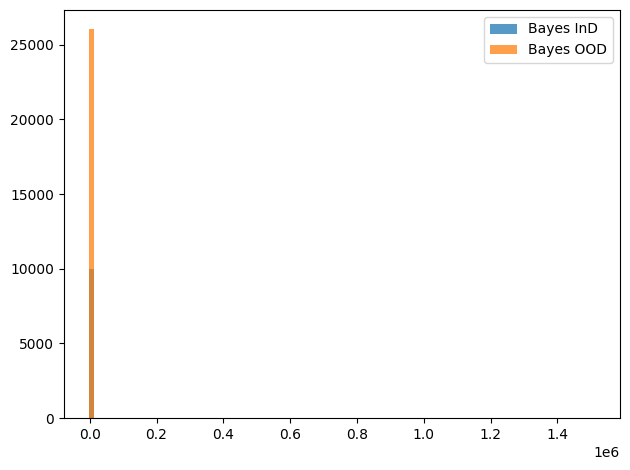

In [30]:
import matplotlib.pyplot as plt

plt.figure()

min_ = np.hstack([excess_scores_ind, excess_scores_ood, bayes_scores_ood, bayes_scores_ind]).min()
max_ = np.hstack([excess_scores_ind, excess_scores_ood, bayes_scores_ood, bayes_scores_ind]).max()
bins = np.linspace(min_, max_, num=100)

# plt.hist(excess_scores_ind, bins=bins, label='Excess InD')
# plt.hist(excess_scores_ood, bins=bins, label='Excess OOD')

plt.hist(bayes_scores_ind, bins=bins, label='Bayes InD', alpha=0.75)
plt.hist(bayes_scores_ood, bins=bins, label='Bayes OOD', alpha=0.75)

plt.legend()
plt.tight_layout()
plt.show();

In [31]:
# grouped_df.brier_brier[
# (grouped_df.brier_brier.training_dataset == 'cifar100') &
# (grouped_df.brier_brier.Dataset == 'cifar10')
# ].sort_values(by='RocAucScore')

In [32]:
def enhance_latex_table(input_latex):
    lines = input_latex.split('\n')
    enhanced_lines = []

    for i, line in enumerate(lines):
        
        if '\\begin{tabular}' in line:
            # Start centering the table
            enhanced_lines.append(r'\begin{center}')
        
        if '\\toprule' in line:
            # Add multicolumn headers
            enhanced_lines.append(line)
            enhanced_lines.append(r'\multicolumn{2}{c}{Dataset} & \multicolumn{5}{c}{Metrics} \\')
            enhanced_lines.append(r'\cmidrule(lr){1-2} \cmidrule(lr){3-7}')
            continue

        # Add row coloring
        if '\\midrule' in line:
            enhanced_lines.append(line)
            enhanced_lines.append(r'\rowcolor{gray!10}')
        elif '\\bottomrule' in line:
            enhanced_lines.append(r'\end{tabular}')
            enhanced_lines.append(r'\end{center}')
        else:
            enhanced_lines.append(line)

    
    return '\n'.join(enhanced_lines)

In [36]:
index_pairs = [
    ( 'CIFAR10',  'Blurred CIFAR10'),
    ( 'CIFAR10', 'Blurred CIFAR100'),
    ( 'CIFAR10',         'CIFAR100'),
    ( 'CIFAR10',             'SVHN'),
    ('CIFAR100',  'Blurred CIFAR10'),
    ('CIFAR100', 'Blurred CIFAR100'),
    ('CIFAR100',          'CIFAR10'),
    ('CIFAR100',             'SVHN')
]

def get_nice_df(df_):
    df_.index = pd.MultiIndex.from_tuples(index_pairs, names=['InD', 'OOD'])
    df_.columns = [
                # 'Bayes',
                # 'Excess',
                # 'Total',
                'Bayes(O)',
                'Bayes(I)',
                'Total(O)',
                'Total(I)',
                'BI',
                'RBI',
                'EPBI',
                # 'Bias',
                # 'MV',
                # 'MVBI',
                # 'BiasBI',
    ]
    # df_ = df_[['Bayes', 'Excess', 'Total', 'BI', 'RBI']]
    df_ = (100 * df_).round(2)

    display(df_)

    return df_, df_.to_latex(float_format="%.2f")

In [37]:
# measures = [c for c in same_agg_df.columns if c not in ['OOD', 'InD', 'ScoringRule']]
# measures

measures = [
    'Bayes Outer',
    'Bayes Inner',
    'Total Outer',
    'Total Inner',
    'Bregman Information',
    'Reverse Bregman Information',
    'Expected Pairwise Bregman Information']

# measures = ['Bayes', 'Excess', 'Total', 'Bregman Information', 'Reverse Bregman Information', 'Expected Pairwise Bregman Information']

In [43]:
nice_same = get_nice_df(same_agg_df[
                        measures
                        ].copy())
enhanced_latex = enhance_latex_table(nice_same[1])
print(enhanced_latex)

Bayes(O)  Bayes(I)  Total(O)  Total(I)     BI  \
InD      OOD                                                               
CIFAR10  Blurred CIFAR10      83.26     85.49     86.30     85.49  87.63   
         Blurred CIFAR100     93.75     95.22     95.62     95.22  95.60   
         CIFAR100             91.11     90.99     90.75     90.99  90.20   
         SVHN                 94.55     94.54     94.34     94.54  93.39   
CIFAR100 Blurred CIFAR10      86.74     89.18     91.45     89.18  85.83   
         Blurred CIFAR100     70.18     72.62     75.68     72.62  76.76   
         CIFAR10              79.25     79.44     79.10     79.44  73.49   
         SVHN                 84.95     84.85     84.33     84.85  75.07   

                             RBI   EPBI  
InD      OOD                             
CIFAR10  Blurred CIFAR10   87.93  87.84  
         Blurred CIFAR100  95.68  95.66  
         CIFAR100          89.96  90.07  
         SVHN              93.23  93.31  
CIFAR100 Blurred CIFAR10   84.48  85.76  
         Blurred CIFAR100  78.03  77.87  
         CIFAR10           71.82  72.78  
         SVHN              72.80  74.11

\begin{center}
\begin{tabular}{llrrrrrrr}
\toprule
\multicolumn{2}{c}{Dataset} & \multicolumn{5}{c}{Metrics} \\
\cmidrule(lr){1-2} \cmidrule(lr){3-7}
 &  & Bayes(O) & Bayes(I) & Total(O) & Total(I) & BI & RBI & EPBI \\
InD & OOD &  &  &  &  &  &  &  \\
\midrule
\rowcolor{gray!10}
\multirow[t]{4}{*}{CIFAR10} & Blurred CIFAR10 & 83.26 & 85.49 & 86.30 & 85.49 & 87.63 & 87.93 & 87.84 \\
 & Blurred CIFAR100 & 93.75 & 95.22 & 95.62 & 95.22 & 95.60 & 95.68 & 95.66 \\
 & CIFAR100 & 91.11 & 90.99 & 90.75 & 90.99 & 90.20 & 89.96 & 90.07 \\
 & SVHN & 94.55 & 94.54 & 94.34 & 94.54 & 93.39 & 93.23 & 93.31 \\
\cline{1-9}
\multirow[t]{4}{*}{CIFAR100} & Blurred CIFAR10 & 86.74 & 89.18 & 91.45 & 89.18 & 85.83 & 84.48 & 85.76 \\
 & Blurred CIFAR100 & 70.18 & 72.62 & 75.68 & 72.62 & 76.76 & 78.03 & 77.87 \\
 & CIFAR10 & 79.25 & 79.44 & 79.10 & 79.44 & 73.49 & 71.82 & 72.78 \\
 & SVHN & 84.95 & 84.85 & 84.33 & 84.85 & 75.07 & 72.80 & 74.11 \\
\cline{1-9}
\end{tabular}
\end{center}
\end{tabular}



In [51]:
nice_same[0].std()

Bayes(O)    8.124515
Bayes(I)    7.692756
Total(O)    7.170457
Total(I)    7.692756
BI          8.584582
RBI         9.116546
EPBI        8.741953
dtype: float64

In [52]:
nice_same[0].mean()

Bayes(O)    85.47375
Bayes(I)    86.54125
Total(O)    87.19625
Total(I)    86.54125
BI          84.74625
RBI         84.24125
EPBI        84.67500
dtype: float64

In [44]:
nice_different = get_nice_df(different_agg_df[
                             measures
                             ].copy())
enhanced_latex = enhance_latex_table(nice_different[1])
print(enhanced_latex)

Bayes(O)  Bayes(I)  Total(O)  Total(I)     BI  \
InD      OOD                                                               
CIFAR10  Blurred CIFAR10      82.56     85.26     86.74     85.26  86.57   
         Blurred CIFAR100     93.45     95.05     95.64     95.05  95.00   
         CIFAR100             90.92     90.99     90.55     90.99  88.34   
         SVHN                 94.41     94.51     94.09     94.51  91.94   
CIFAR100 Blurred CIFAR10      86.36     88.94     86.98     88.94  76.98   
         Blurred CIFAR100     69.42     72.56     74.54     72.56  71.87   
         CIFAR10              78.71     79.03     74.26     79.03  64.67   
         SVHN                 84.87     84.95     79.29     84.95  66.20   

                             RBI   EPBI  
InD      OOD                             
CIFAR10  Blurred CIFAR10   86.46  86.73  
         Blurred CIFAR100  94.71  95.12  
         CIFAR100          88.04  88.25  
         SVHN              91.75  92.00  
CIFAR100 Blurred CIFAR10   75.04  78.02  
         Blurred CIFAR100  72.99  73.63  
         CIFAR10           63.30  64.61  
         SVHN              64.34  65.84

\begin{center}
\begin{tabular}{llrrrrrrr}
\toprule
\multicolumn{2}{c}{Dataset} & \multicolumn{5}{c}{Metrics} \\
\cmidrule(lr){1-2} \cmidrule(lr){3-7}
 &  & Bayes(O) & Bayes(I) & Total(O) & Total(I) & BI & RBI & EPBI \\
InD & OOD &  &  &  &  &  &  &  \\
\midrule
\rowcolor{gray!10}
\multirow[t]{4}{*}{CIFAR10} & Blurred CIFAR10 & 82.56 & 85.26 & 86.74 & 85.26 & 86.57 & 86.46 & 86.73 \\
 & Blurred CIFAR100 & 93.45 & 95.05 & 95.64 & 95.05 & 95.00 & 94.71 & 95.12 \\
 & CIFAR100 & 90.92 & 90.99 & 90.55 & 90.99 & 88.34 & 88.04 & 88.25 \\
 & SVHN & 94.41 & 94.51 & 94.09 & 94.51 & 91.94 & 91.75 & 92.00 \\
\cline{1-9}
\multirow[t]{4}{*}{CIFAR100} & Blurred CIFAR10 & 86.36 & 88.94 & 86.98 & 88.94 & 76.98 & 75.04 & 78.02 \\
 & Blurred CIFAR100 & 69.42 & 72.56 & 74.54 & 72.56 & 71.87 & 72.99 & 73.63 \\
 & CIFAR10 & 78.71 & 79.03 & 74.26 & 79.03 & 64.67 & 63.30 & 64.61 \\
 & SVHN & 84.87 & 84.95 & 79.29 & 84.95 & 66.20 & 64.34 & 65.84 \\
\cline{1-9}
\end{tabular}
\end{center}
\end{tabular}



In [53]:
nice_different[0].mean()

Bayes(O)    85.08750
Bayes(I)    86.41125
Total(O)    85.26125
Total(I)    86.41125
BI          80.19625
RBI         79.57875
EPBI        80.52500
dtype: float64

In [54]:
nice_different[0].std()

Bayes(O)     8.324288
Bayes(I)     7.721749
Total(O)     8.370061
Total(I)     7.721749
BI          11.836036
RBI         12.289760
EPBI        11.745028
dtype: float64

In [41]:
print(enhance_latex_table(pd.concat([nice_same[0], nice_different[0]], axis=1).to_latex(float_format="%.2f")))

\begin{center}
\begin{tabular}{llrrrrrrrrrrrrrr}
\toprule
\multicolumn{2}{c}{Dataset} & \multicolumn{5}{c}{Metrics} \\
\cmidrule(lr){1-2} \cmidrule(lr){3-7}
 &  & Bayes(O) & Bayes(I) & Total(O) & Total(I) & BI & RBI & EPBI & Bayes(O) & Bayes(I) & Total(O) & Total(I) & BI & RBI & EPBI \\
InD & OOD &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\rowcolor{gray!10}
\multirow[t]{4}{*}{CIFAR10} & Blurred CIFAR10 & 83.26 & 85.49 & 86.30 & 85.49 & 87.63 & 87.93 & 87.84 & 82.56 & 85.26 & 86.74 & 85.26 & 86.57 & 86.46 & 86.73 \\
 & Blurred CIFAR100 & 93.75 & 95.22 & 95.62 & 95.22 & 95.60 & 95.68 & 95.66 & 93.45 & 95.05 & 95.64 & 95.05 & 95.00 & 94.71 & 95.12 \\
 & CIFAR100 & 91.11 & 90.99 & 90.75 & 90.99 & 90.20 & 89.96 & 90.07 & 90.92 & 90.99 & 90.55 & 90.99 & 88.34 & 88.04 & 88.25 \\
 & SVHN & 94.55 & 94.54 & 94.34 & 94.54 & 93.39 & 93.23 & 93.31 & 94.41 & 94.51 & 94.09 & 94.51 & 91.94 & 91.75 & 92.00 \\
\cline{1-16}
\multirow[t]{4}{*}{CIFAR100} & Blurred CIFAR10 & 86.74 & 89.18 & 91.45

In [42]:
(same_agg_df - all_agg_df) > 0

Total Outer Total Inner Bayes Inner Bayes Outer  \
                                 mean        mean        mean        mean   
InD      OOD                                                                
cifar10  blurred_cifar10        False        True        True        True   
         blurred_cifar100       False        True        True        True   
         cifar100                True        True        True        True   
         svhn                    True        True        True        True   
cifar100 blurred_cifar10         True        True        True        True   
         blurred_cifar100        True        True        True        True   
         cifar10                 True        True        True        True   
         svhn                    True       False       False        True   

                          Excess Bregman Information  \
                            mean                mean   
InD      OOD                                           
cifar10  blurred_cifar10    True                True   
         blurred_cifar100   True                True   
         cifar100           True                True   
         svhn               True                True   
cifar100 blurred_cifar10    True                True   
         blurred_cifar100   True                True   
         cifar10            True                True   
         svhn               True                True   

                          Reverse Bregman Information  \
                                                 mean   
InD      OOD                                            
cifar10  blurred_cifar10                         True   
         blurred_cifar100                        True   
         cifar100                                True   
         svhn                                    True   
cifar100 blurred_cifar10                         True   
         blurred_cifar100                        True   
         cifar10                                 True   
         svhn                                    True   

                          Expected Pairwise Bregman Information  Bias    MV  \
                                                           mean  mean  mean   
InD      OOD                                                                  
cifar10  blurred_cifar10                                   True  True  True   
         blurred_cifar100                                  True  True  True   
         cifar100                                          True  True  True   
         svhn                                              True  True  True   
cifar100 blurred_cifar10                                   True  True  True   
         blurred_cifar100                                  True  True  True   
         cifar10                                           True  True  True   
         svhn                                              True  True  True   

                           MVBI BiasBI  
                           mean   mean  
InD      OOD                            
cifar10  blurred_cifar10   True   True  
         blurred_cifar100  True   True  
         cifar100          True   True  
         svhn              True   True  
cifar100 blurred_cifar10   True   True  
         blurred_cifar100  True   True  
         cifar10           True   True  
         svhn              True   True